In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

This uses the default main branch of whr. e.g. it will use "black/white" to refer to the winner. "White" is second. 

In [2]:
data_path = '../data/cfbd/games_1869_to_2020.csv'

In [3]:
games_df = pd.read_csv(data_path)
#games_df = games_df[games_df.season>2010]
games_df.shape

/home/ryan/Develop/cfb/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(79805, 25)

win_prob with 2.5 home field =  1/(1+10^(2.5/13))
win_prob with 400 elo scale =  1/(1+10^(x/400))

elo handicap for 2.5 points = 2.5/13 * 400 = 77

In [4]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")

In [5]:
scale = 13
w2 = 500
whr = whole_history_rating.Base({'scale': scale,'w2':w2, 'debug':False})

In [6]:
start_time = 0
home_team_handicap = 2.5/13*scale
verbose = False
for i,row in games_df.iterrows():
    game_time = datetime_from_cfbd(row.start_date)
    if start_time == 0: start_time = game_time
    days = (game_time-start_time).days
    home_team = row.home_team
    away_team = row.away_team
    handicap = -(1-row.neutral_site)*home_team_handicap
    mov = row.home_points-row.away_points
    winner = "W" if mov>0 else "B"
    if mov==0: continue
        
    if verbose: print("away team: {}, home team: {}".format(away_team,home_team))
    if verbose: print("winner: {} (W is home), days: {} handicap: {}".format(winner,days,handicap))
    whr.create_game(away_team,home_team,winner, days, handicap)
    #if len(whr.games) > 100: break

In [7]:
len(whr.games)

77239

timing:

100 games: 0.21831806499903905

1000:      4.505260759000521

8332:      15.015844893998292

23179:     58.9916944889992

74781:     241.91250731699984

77239:     

In [8]:
start_perf_timer = time.perf_counter()
whr.auto_iterate(time_limit = 10, precision = 10E-4*scale/400)
end_perf_timer = time.perf_counter()
end_perf_timer-start_perf_timer

214.97095831300248

In [9]:
def get_player_history(player_name,start_time=0, seasons=[]):
    ratings = whr.ratings_for_player(player_name)
    if start_time:
        ratings = [[dt.timedelta(days=d)+start_time,elo,unc] for d,elo,unc in ratings]
    return ratings

In [10]:
players = [
           #'Texas A&M',
           'Ohio State',
           'Alabama',
           'Clemson',
           #'Minnesota',
           #'LSU',
           #'Vanderbilt',
           #'Florida State',
           'Harvard',
           'Yale',
           'Princeton'
           #'UAB',
           #'North Dakota State',
          ]

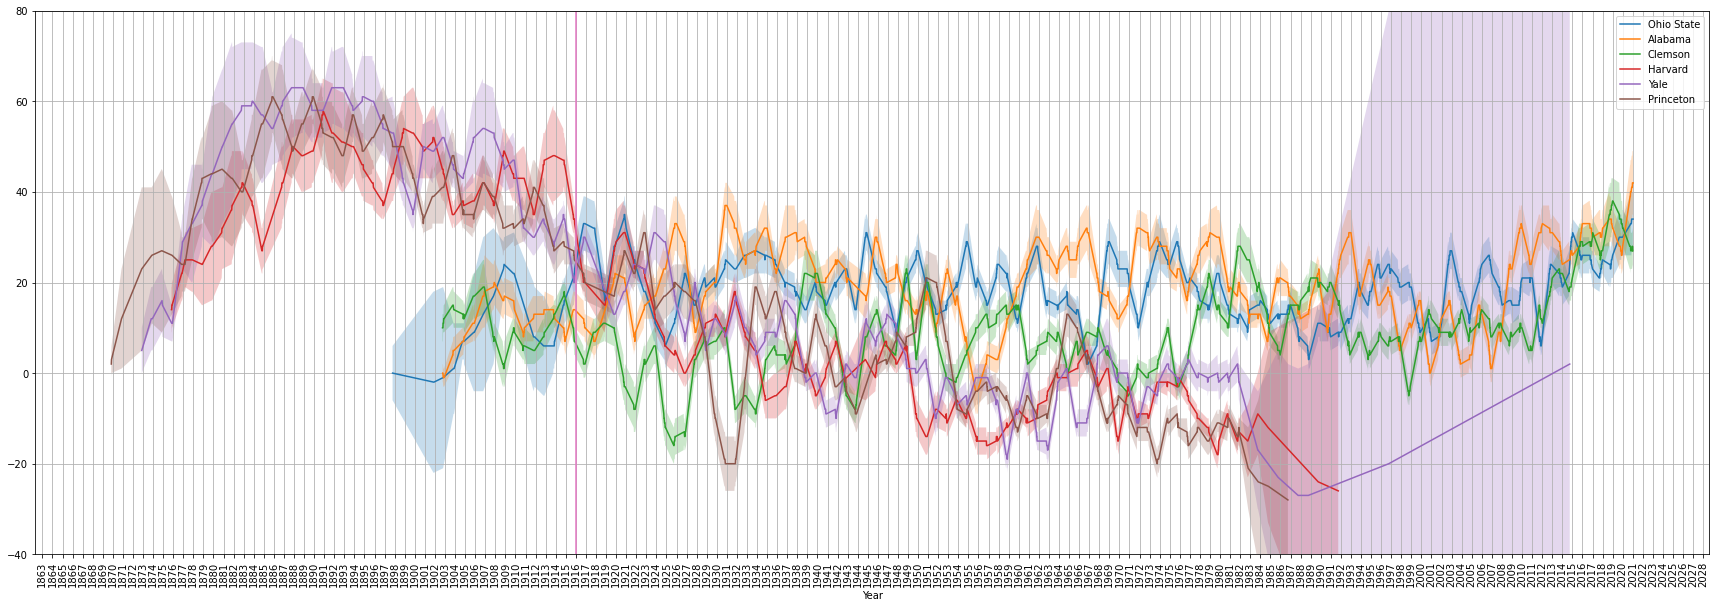

In [19]:
fig = plt.figure(figsize=[30,10])
for player in players:
    player_details = get_player_history(player,start_time=start_time)
    dates,ratings,uncertainties = list(zip(*player_details))
    ratings,uncertainties = np.asarray(ratings),np.asarray(uncertainties)
    plt.plot(dates,ratings,label=player)
    #plt.scatter(dates,ratings)
    up,down = ratings+uncertainties, ratings-uncertainties
    plt.fill_between(dates,up,down, alpha=.25)
    
    
x_no_scholarships = [dt.date(1916,1,1) for i in range(2)]
y = [-40,80]
plt.plot(x_no_scholarships,y)
    
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

ax = fig.axes[0]
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.grid(True)
#fig.autofmt_xdate()

plt.ylim((-40,80))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Year')
plt.savefig('scale_{}_w_{}.pdf'.format(scale,w2))


In [12]:
whr.print_ordered_ratings(current=True)

Guilford => -57.19939996827512
Morgan State => -53.58164027765144
City College of New York => -53.55212381126075
VMI => -52.48159052483076
Piedmont => -51.27296046207789
South Dakota Mines => -49.791245514364284
Adams State => -49.47720642731598
Nebraska Wesleyan => -49.385647183569844
Tennessee Tech => -49.22232919038366
Willamette => -48.61583110300583
Wagner => -47.96157576450522
Northern Colorado => -47.877718943497534
Prairie View => -47.520803914847725
La Verne => -47.235973809360694
Erskine => -46.96844959238662
Texas Southern => -46.7000627705589
Truman State => -46.69911251116059
Murray State => -46.514955402127136
California Tech => -46.49543076060512
New Mexico Military => -46.25871275089887
Fort Hays State => -46.2162099872808
Austin Peay => -46.101302825790015
Central (Iowa) => -45.85928599786022
Baker => -45.57246206873567
Norfolk State => -45.54502878844171
Wayne State => -45.3448564144714
Emory & Henry => -45.307118162416835
Brooklyn => -44.80829985443394
Southeastern L

Fort Sheridan => 3.2337398682465115
Texas Tech => 3.3239383704104153
SMU => 3.3460847955608766
Alameda Coast Guard => 3.3745270173395547
UCLA => 3.4025691927703465
Fort Lewis => 3.414319739550968
Bradley => 3.536983836539185
New London Submarine Base => 3.574827305842286
Arizona State => 3.591226802607972
Army => 3.598247125361973
Virginia => 3.696701480147092
Monticello Navy => 3.796435067682142
UAB => 3.9145485741898285
Kelly Field => 3.9397626471007925
Orange A.C. => 3.9569208015985766
Illinois Alumni => 3.966292713871203
Garden City => 4.01754610338177
Newark A.C. => 4.061779285765028
Atlantic City NAS => 4.121002074905816
Reliance A.C. => 4.143875345412532
Virginia Tech => 4.173593433341249
Lincoln Field => 4.306789675584864
Pacific Lutheran => 4.3368662548997055
John Carroll => 4.425769430422499
Camp Davis => 4.460879141685813
Camp Taylor => 4.496286359205288
Daniel Field => 4.542877186076246
University Club of Chicago => 4.598207607192707
Greensboro Field => 4.6200581851280855
S